# 从Transformer编码器到BERT

## 1. BERT是什么


BERT全称**B**idirectional **E**ncoder **R**epresentation from **T**ransformers

中文直译为：Transformer获得的双向编码器表征

给它一个中文学术风的名字：基于Transformer架构的双向编码器表征模型

我们先完全从它的名字来了解BERT是什么：

- BERT是一个**表征模型（Representation Model）**：表征一般指使用低维度的向量（表征向量）来表示高维度的数据（如文本、图像等）。
- BERT是一个**编码器（Encoder）**：编码器是相对解码器（Decoder）而言的一个概念，本质上也是一种表征模型，把高维度数据编码成低维度的向量。解码器则是相反的，把低维的向量解析为高维的数据。
- BERT是一个**双向（Bidirectional）编码器**：单向/双向一般都是针对时间序列数据而言的，双向编码器表示，在计算表征向量的过程中，序列中的每个元素可以看到其前面和其后面的元素的信息。单向编码器则只能看到前面或只能看到后面的信息。
- BERT是基于**Transformer**架构的：Transformer由编码器和解码器组成，前面已知BERT是一个编码器，那么可以推测，BERT应该是用到了Transformer的编码器部分。

## 2. 表征模型是什么

### 2.1 表征任务与分类/回归等任务的区别

在[详解神经网络的训练](https://colab.research.google.com/drive/1nWz3-wz9WouCE6KW_Yn4m6HzGQM39VSC)中我们介绍了分类任务（预测离散的类别标签），将鸢尾花分为3类。

在[Self-Attention训练流程详解](https://colab.research.google.com/drive/1d7qfwr32lkq3hZEZ1jNaIJ7Rz8zLNkfl)中，我们介绍了回归任务（预测连续的数值），对下个交易日的开盘价格进行预测。

这两种任务对于所需要找的函数$f$都有明确的衡量标准：

- 分类任务：输入鸢尾花的花瓣和花萼数据$\mathbf{x}$，$f$输出鸢尾花属于每个类别的概率$y_1,y_2,y_3$，正确的类别的概率越大，说明$f$越好
- 回归任务：输入前3-5个交易日的数据$X$，$f$输出下一个交易日的开盘价$y$，与正确开盘价的差别越小，说明$f$越好

而表征模型的任务是要找到一个表征函数$f$，可以将原始数据$X$（如文本、图像）映射为一个表征向量$\mathbf{h}$，即$\mathbf{h}=f(X)$。

然而，这个函数输出的表征向量$\mathbf{h}$并没有明确的含义。

在分类/回归任务中，我们可以用真实的分类标签/真实的数值来衡量函数$f$输出的好坏。

在表征任务中，我们没有办法直接去衡量表征模型输出的表征向量$\mathbf{h}$的好坏。

例如，在[手把手教你编写Transformer编码器](https://colab.research.google.com/drive/1Q_Z5LimF_1dV6g0untBH_vMm12ilEGUf)中，我们构建了一个嵌入函数，将单词/token表征为向量，但是我们却还没有讲到怎么衡量这个表征向量的好坏。

### 2.2 在进一步的任务上衡量表征向量的好坏

事实上，我们只有进一步拿表征向量去做具体的任务，才能衡量表征向量在这一具体任务中的好坏。

例如，假设有一个表征函数$f$，它针对数据$\mathbf{x}$计算的表征向量的过程表示为：

$$
\mathbf{h}=f(\mathbf{x})=W_1^T\mathbf{x}+\mathbf{b}_1
$$

由于$\mathbf{h}$没有具体含义，我们没法衡量$\mathbf{h}$的好坏。

因此我们利用$\mathbf{h}$做进一步的分类任务：假设现在还有一个函数$g$，它的目的是计算$X$所属的类别（3-分类），但是它不直接接收$\mathbf{x}$作为输入，而是接收$\mathbf{x}$的表征向量$\mathbf{h}$作为输入（表征向量$\mathbf{h}$的目的就是用来代表原始数据$\mathbf{x}$去做具体的分类/回归任务），然后输出$\mathbf{x}$属于各个分类的概率$y_1,y_2,y_3$：

$$
(y_1,y_2,y_3)=g(\mathbf{h})=W_2^T\mathbf{h}+\mathbf{b}_2
$$

显然，$g(\mathbf{h})$可以进一步展开写成：

$$
\begin{aligned}
(y_1,y_2,y_3)=g(\mathbf{h})&=W_2^T\mathbf{h}+\mathbf{b}_2 \\
&=W_2^Tf(\mathbf{x})+\mathbf{b}_2 \\
&=W_2^T(W_1^T\mathbf{x}+\mathbf{b}_1)+\mathbf{b}_2 \doteq g(\mathbf{x})
\end{aligned}
$$

最终得到的函数解析式是关于$\mathbf{x}$的函数，因此写成$g(\mathbf{x})$。

而$g(\mathbf{x})$的输出$(y_1,y_2,y_3)$是有具体含义的，及三种类别的概率，可以用交叉熵损失（详见[详解神经网络的训练](https://colab.research.google.com/drive/1nWz3-wz9WouCE6KW_Yn4m6HzGQM39VSC)）衡量其好坏（$y_\text{true}$是真实类别）：

$$
L(g)=\text{CrossEntropy}(g(\mathbf{x}),y_\text{true})
$$

损失函数$L$关于参数$W_1$和$W_2$的梯度都可求，$W_1$和$W_2$同时沿相应的梯度更新，即可使$L$最小化。

### 2.3 表征函数的最优性

假设使$L$最小的参数（即最优参数）为$W_1^*$和$W_2^*$，那么显然我们可以说$g^*(\mathbf{x})={W_2^*}^T({W_1^*}^T\mathbf{x}+\mathbf{b}_1)+\mathbf{b}_2$是一个最优的分类函数

同时，也可以说$f^*(\mathbf{x})={W_1^*}^T\mathbf{x}+\mathbf{b}_1$在**特定条件**下是一个最优的表征函数，这个条件是，$f^*$的输出要被进一步输入到$g^*$进行分类任务。

表征模型最优的条件很严苛，但是很多时候我们并不需要它最优。换言之，$f^*$不只是针对最优分类器$g^*$有效。

比如，我们如果还需要训练另一个分类函数$\phi(\mathbf{h})$，同样也是接收表征而不是原始数据作为输入，那么此时使用$f^*$计算表征通常而言会比使用$f$计算表征要好。即，$\phi$能更快地被训练成一个最优的分类函数。

### 2.4. 表征模型的用途

在[Self-Attention训练流程详解](https://colab.research.google.com/drive/1d7qfwr32lkq3hZEZ1jNaIJ7Rz8zLNkfl)中，我们构建了这样一个模型结构来预测股票开盘价：

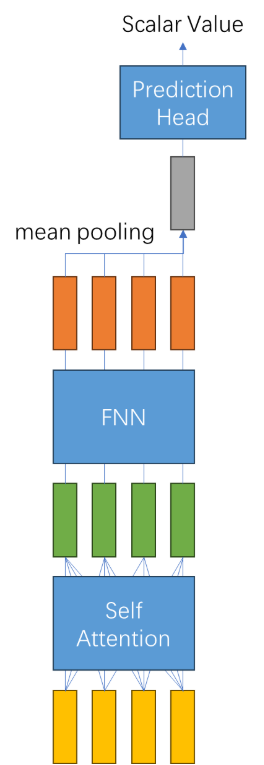

我们可以说，我们把4个交易日的序列数据（黄色）$X$表征成了表征向量（灰色）$\mathbf{h}$，然后把表征向量输入预测函数（模型）Prediction Head中得到最终的交易价格值。

其中Self Attention和FNN两个模块堆叠（再加上pooling的操作）共同组成了表征模型，它可以把序列数据表征成一个向量。

最后的Prediction Head则是利用表征向量（而非原始数据）进行预测的模型。

经过开盘价预测任务训练后，这个模型整体上是一个表现良好的开盘价预测模型，而这个模型去除Prediction Head后剩余的部分也可以作为一个良好的表征模型。

这个表征模型可以有如下用途：

1. 为两条序列数据$X_1,X_2$计算表征向量$\mathbf{h}_1,\mathbf{h}_2$，计算$\mathbf{h}_1,\mathbf{h}_2$的余弦相似度作为$X_1,X_2$的相似度
2. 假如有一个新的任务要求预测**收盘价**，除了另起一个新的随机初始化参数的模型，还可以尝试使用已经学到的表征模型，只随机初始化Prediction Head部分的参数。虽然这个表征模型是从预测开盘价而非收盘价的任务中学到的，但是也可能比随机初始化的表征模型更有利于收盘价的预测（具体需要通过实验验证，也完全有可能不如随机初始化）

## 3. 将Transformer编码器训练成一个句子表征模型

本节我们讲解如何利用Transformer编码器训练一个句子表征模型，即从Transformer到BERT的过程。

### 3.0 自编码器和去噪自编码器

在介绍BERT如何利用Transformer编码器训练句子表征模型之前，需要介绍一下两种非常经典的模型结构：自编码器和去噪自编码器。BERT与它们的训练方式有异曲同工之妙。

自编码器（Auto-encoder）和去噪自编码器（Denoising Auto-encoder）是训练表征模型的两种常见的架构。

我们在前面讲到，要训练表征模型必须利用表征向量做进一步的有监督的任务（如分类、回归等），这就需要用到昂贵的监督数据，并且训练出来的表征可能只适用于特定的任务。

自编码器解决了这一烦恼，既不需要引入额外的监督学习任务，同时也减小了对表征向量泛化性的影响。

自编码器的一般结构如下：

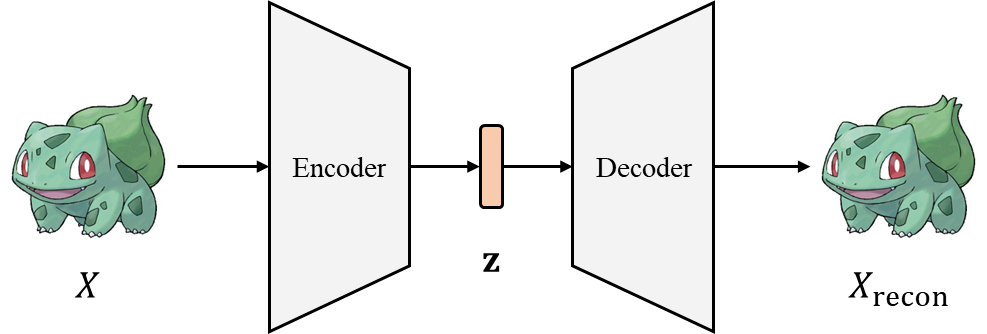

自编码器首先利用编码器将高维数据$X$映射为表征向量$\mathbf{z}$，然后利用解码器将表征向量$z$重构为高维数据$X_\text{recon}$，并期待通过$\mathbf{z}$重构出来的$X_\text{recon}$与原始数据$X$是一模一样的。

经过适当的训练后，编码器部分就成为了一个优秀的表征模型，因为它根据$X$所得到的$\mathbf{z}$是有办法（利用Decoder）被还原成$X$的（即使还原出来不是完美的），这说明表征向量$\mathbf{z}$中包含了高维数据$X$中足够多的信息。

去噪自编码器与自编码器只有细微的区别——编码器的输入从原始数据变成了加噪数据，但是所期待的解码器的输出仍然是原始数据：

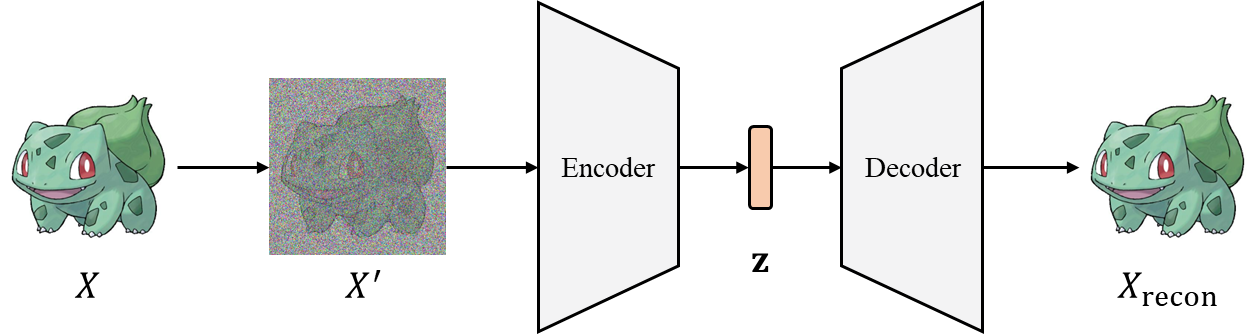

去噪自编码器对Encoder的表征能力有了更高的要求，要求它从带噪声的数据中还原出被噪声所覆盖的信息。

去噪编码器在训练时一般会接受带不同程度噪声的数据（包括不带噪声的数据）作为输入
- 一方面是因为在训练完成后用作表征模型时，接收的输入一般是不带噪声的数据，如果训练时只看过加噪的数据显然不行；
- 另一方面，带不同程度噪声的数据都要求被还原成相同的原始数据，通过这样的训练可以使同一条原始数据对应的不同噪声的表征一致，这样，即使训练完成后用作表征模型时看到的数据是带噪声的，也能免受其扰。

### 3.1 BERT表征模型架构

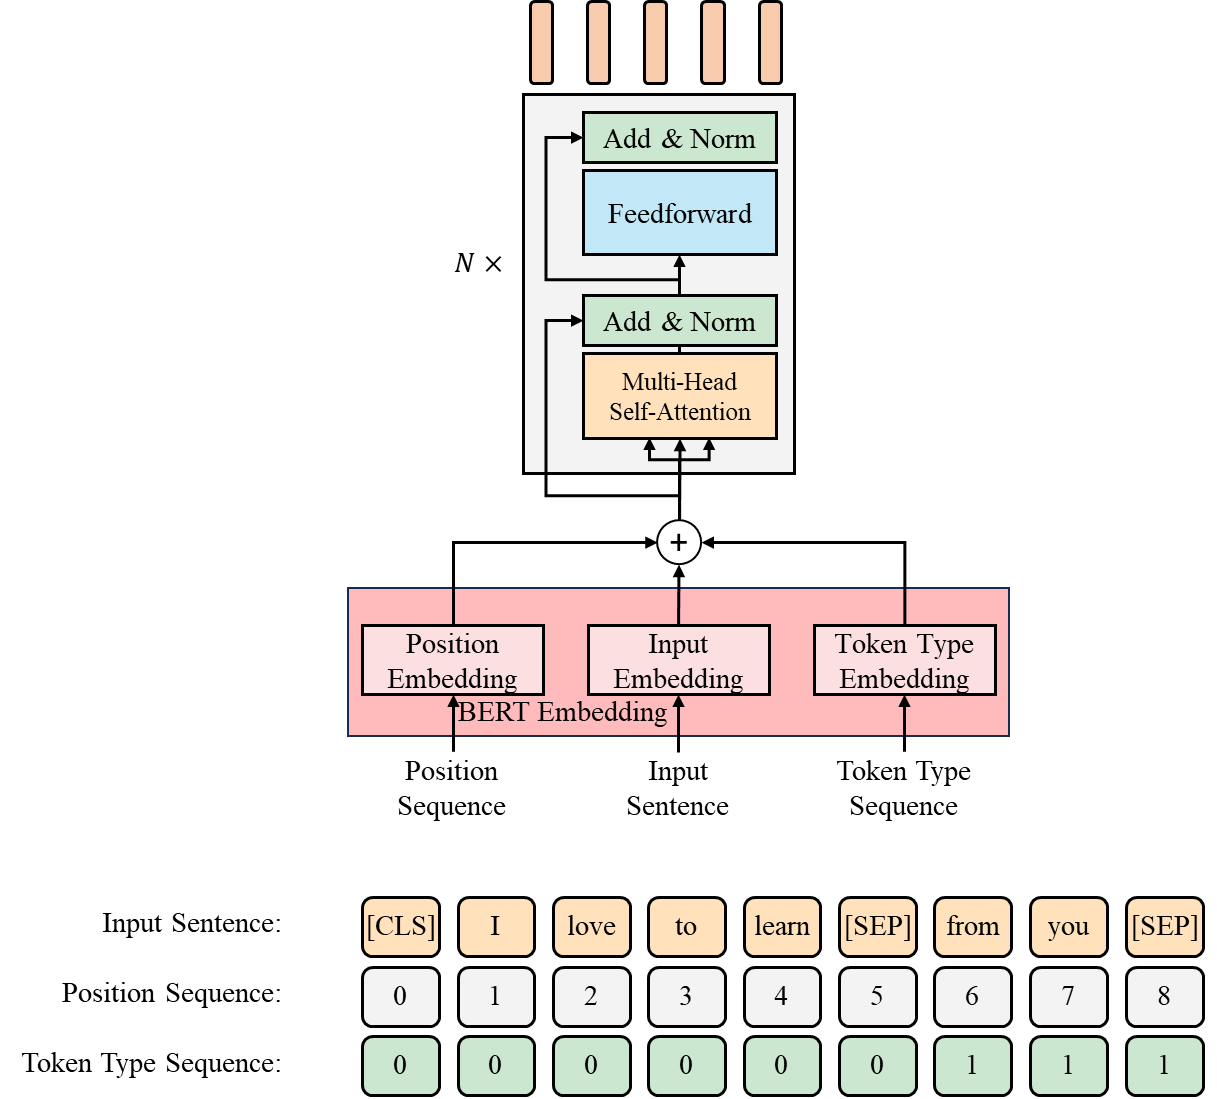

与原始Transformer架构相比:

- BERT模型将Positional Encoding替换成了可学习的Position Embedding，与我们上节课的实现一致
- BERT模型还会接收一个Token Type Sequence作为输入。Token Type Sequence把句子标记成两个片段，我们在后面会讨论它的作用。

注意到，输入的token序列中加入了特殊token，一个是`[CLS]`，表示句子的开头，另一个是`[SEP]`，表示句子的结束。`[SEP]`放在末尾，或用来分隔两个句子。

根据输入句子即可推断出Position Sequence和Token Type Sequence，因此我们在后面的图示表达中可能省略Position Sequence和Token Type Sequence.

堆叠的$N$个Encoder Block所输出的向量（橙色）可以看作是每个对应位置token的表征向量。

然而这些表征向量。那么我们用什么进一步的具体任务来训练这些表征向量呢？

下面介绍两种用来训练表征向量的任务。

### 3.2 完形填空任务：Masked Language Modeling (MLM)

之前李宏毅老师介绍过GPT中的“文字接龙”。

“文字接龙”的目标是，给定一个未完成的句子，预测句子中应该出现的下一个词。

例如，对于“机器学习”这个句子，我们期望能找到一个函数$f$，满足：

$$
\begin{aligned}
f(\text{[CLS]})=机 \\
f(\text{[CLS]}机)=器 \\
f(\text{[CLS]}机器)=学 \\
f(\text{[CLS]}机器学)=习 \\
f(\text{[CLS]}机器学习)=\text{[SEP]}
\end{aligned}
$$

其中`[CLS]`和`[SEP]`表示句子的开始和结束。

“文字接龙”是一种语言建模目标，因为它构建了一个模型，这个模型掌握了人类语言的某种规律——根据未完成的句子预测下一个单词。

MLM同样也是一种语言建模目标，但它不是“文字接龙”，它是“完形填空”。

例如，对于“机器学习”这个句子，我们把其中的一部分词掩盖掉，变我们希望找到一个函数$f$，它可以把被掩盖的词还原出来：

$$
\begin{aligned}
f(机器\text{[MASK]}习) = 机器学习\\
f(\text{[MASK]}器学习) = 机器学习\\
f(机器学\text{[MASK]}) = 机器学习\\
f(机\text{[MASK]}学习) = 机器学习\\
f(机\text{[MASK]}\text{[MASK]}习)= 机器学习\\
\vdots
\end{aligned}
$$

MLM整体流程的示意图如下：

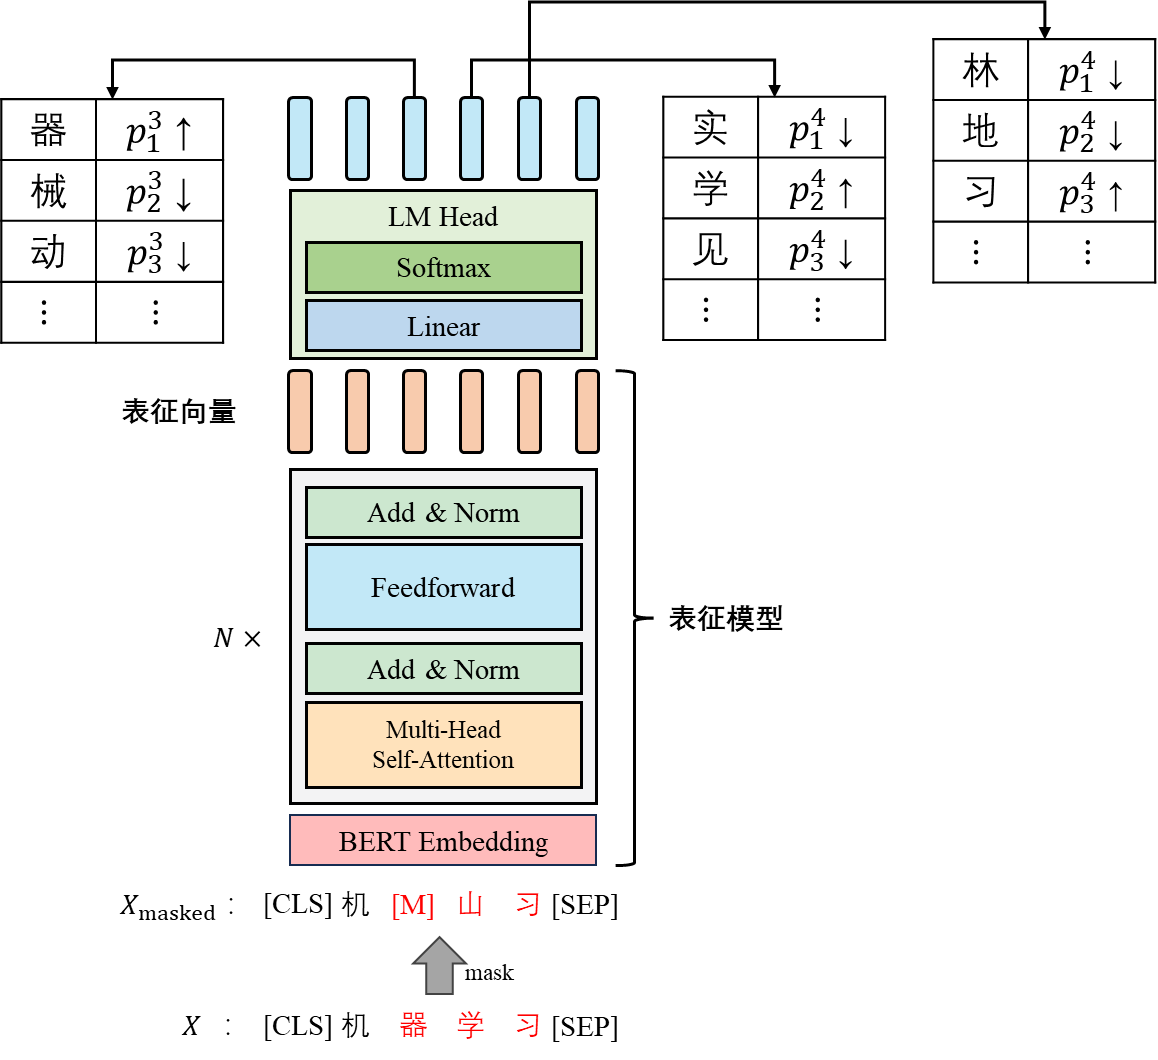

1. 给定一个句子$X$，首先随机选中其中一部分词（“器”，“学”，“习”）（PS: 实际上不可能有75%这么高的选中比例，一般设为20%左右，这里是为了方便演示）
2. 对于选中的词，有三种处理方式
  - 将其替换为特殊记号`[MASK]`（简写`[M]`）
  - 将其替换为词表中的另一个词（“学”=>“山”）
  - 保持这个词不变（“习”=>“习”）

  PS: 之所以不全部替换为`[MASK]`，是因为在测试时，模型的输入不包含`[MASK]`（因为我们希望获取一个原始句子的表征），需要在训练时让模型看过这种情况。

  PS: 选中后保持不变和不选中也是有区别的，只有被选中的单词才会参与loss计算。
2. 将$X_\text{masked}$输入到BERT模型的主体结构中（包括BERT Embedding和N个堆叠的Encoder块），得到一排表征向量（橙色）
3. 分别将每个表征向量输入到Language Modeling (LM) Head，将表征向量映射为词表上的概率分布（蓝色）
4. 只考虑被选中的位置的概率分布，期望该位置预测为正确单词（即$X$中原有的单词）的概率增大，预测为错误单词的概率减小。

注意到，“完形填空”与“文字接龙”都是自监督（Self-Supervised）学习，只需要有文字数据，不需要像分类和回归任务一样对数据进行标注（标注类别和真实值）。通过句子本身就可以构建输入和目标输出：

- 文字接龙：输入是未完成的句子，目标输出是句子的下一个单词
- 完形填空：输入时被掩盖的句子，目标输出是原始未被掩盖的句子


从上图中可以看到，这里我们把整个用于MLM任务的模型划分成了表征模型和LM Head部分：
- 这里的表征模型可以对应Auto-encoder中的Encoder，它把句子映射为一排表征向量
- 而LM Head可以对应Auto-encoder中的Decoder，它把一排表征向量映射回句子（注意区分Auto-encoder中的decoder和Transformer的decoder，目前我们还没有用到Transformer的Decoder）

而整个MLM所采用的架构可以看作一个Denoising Auto-encoder，因为我们给encoder的输入是带噪声的（`[MASK]`以及随机替换的字符）。

如果我们提供大量的语料并进行合适且足够的MLM训练，MLM就能根据加噪的句子还原出原始的句子，具体而言，LM Head能从表征模型的输出中还原出原始句子，这也就意味着表征模型输出的表征向量中包含了整个句子的信息。

### 3.3. 文本匹配任务：Next Sentence Prediction (NSP)

BERT中还引入了与MLM并列的一项任务，即文本匹配任务。

文本匹配任务就是要检查输入的两个句子是否属于前后相连的两个句子，如下图所示：

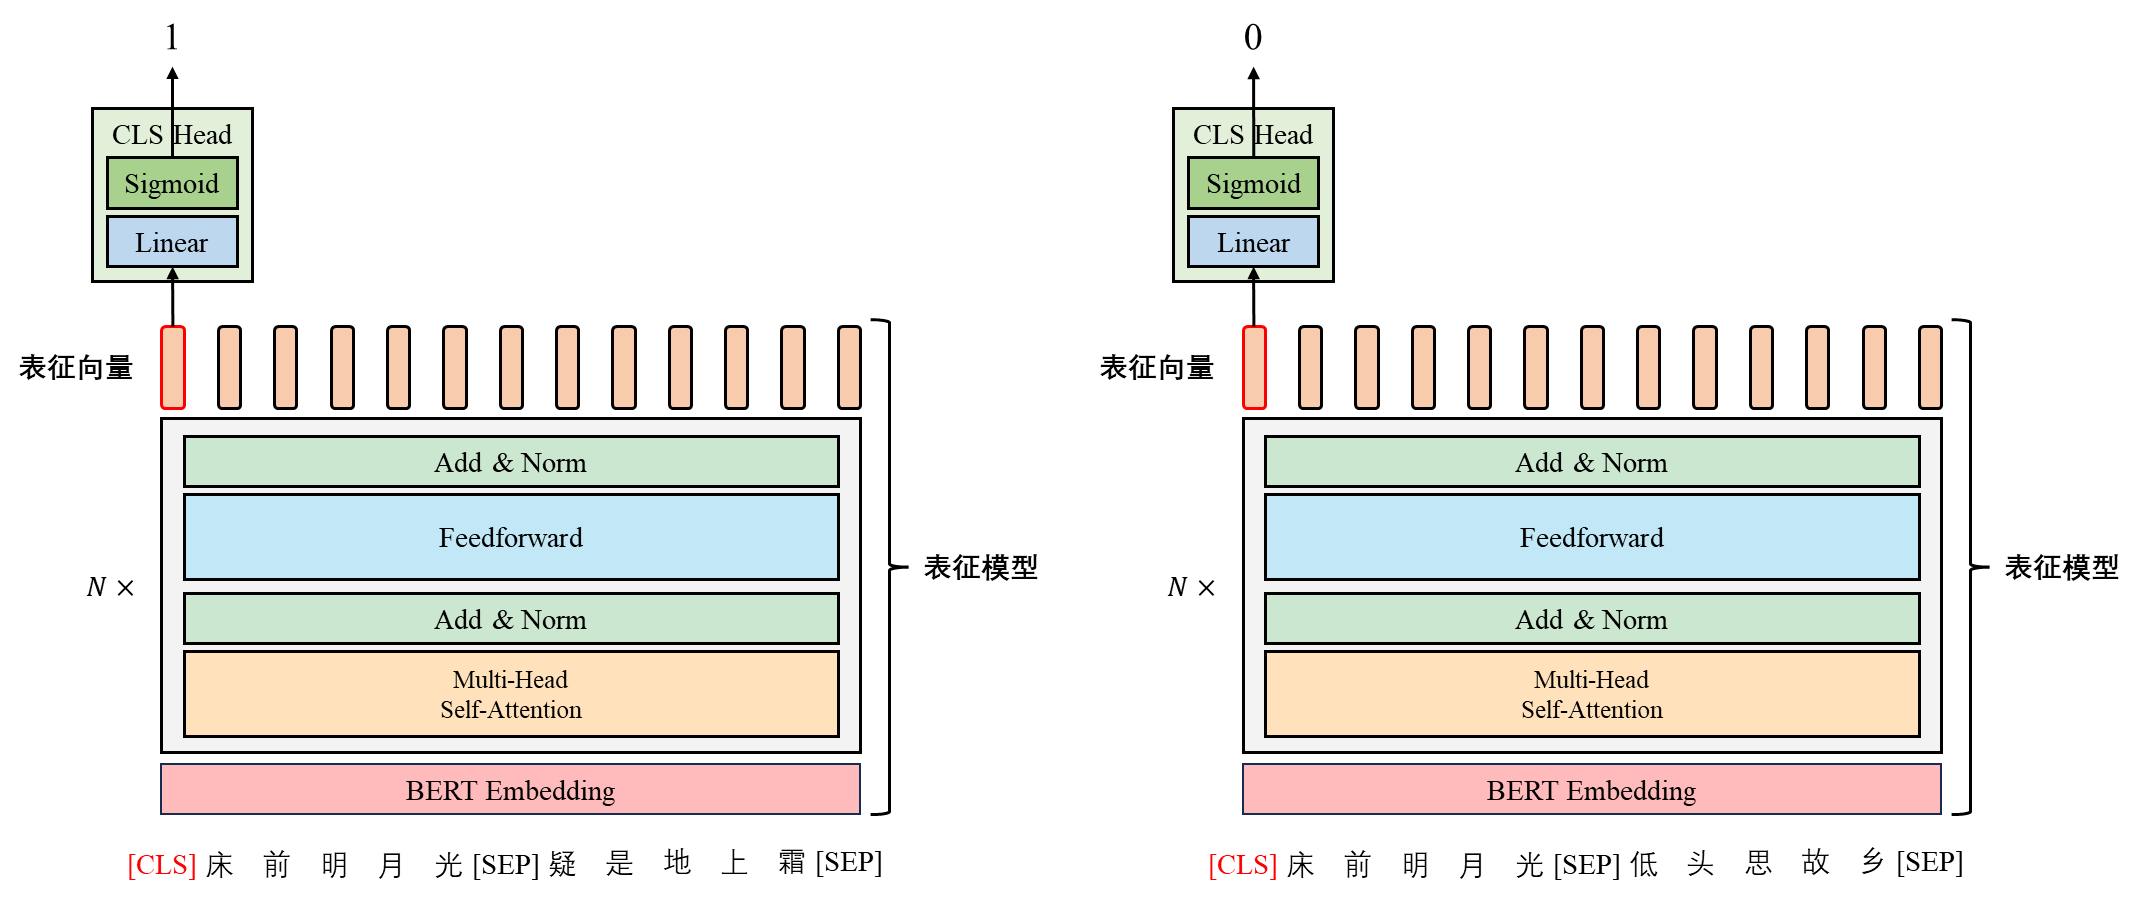

左边“床前明月光”和“疑是地上霜”是相连的同一个句子，因此目标输出是1

右边“床前明月光”和“低头思故乡”不是相连的同一个句子，因此目标输出是0

因此，这个任务又叫Next Sentence Prediction (NSP)，是一个二分类任务。

注意，这里只使用了`[CLS]`位置（即第1个位置）的表征向量，将其输入到CLS Head中，经过线性层映射为标量，再经过Sigmoid激活函数映射为0-1之间的值。

因为Encoder Block（灰色）中的多头注意力机制（橙色）可以使得输出的每个表征向量都包含序列中所有位置上的信息，因此可以只取输出序列中的一个向量来表征整个句子。

NSP任务的必要性存在争议，在一些BERT的改进工作中只保留了MLM任务，去除了NSP任务。

### 3.4 预训练和微调

BERT论文中的实验使用BooksCorpus（包含约8亿个英文单词）和English Wikipedia（包含约25亿个英文单词）两个巨大的语料库，训练Transformer编码器完成MLM和NSP任务。这个过程称为预训练（Pre-Training）。

预训练过程是无监督（自监督）学习的过程，没有引入任何标注数据，完全依靠语料本身构建MLM和NSP的训练数据。

预训练过程没有完成实际应用中的具体任务，这些具体任务将在完成预训练之后，通过微调训练（Fine-Tuning）来完成。

## 4. 自然语言理解任务

本节来了解常见的自然语言理解（Natural Language Understanding, NLU）任务

### 4.1 GLUE
**GLUE（General Language Understanding Evaluation）**是一个多任务的自然语言理解（Natural Language Understanding, NLU）基准和分析平台，其中包含了多个自然语言理解任务的基准数据集：

**1. CoLA (The Corpus of Linguistic Acceptability)**：句子分类任务，判断每个句子的语法是否正确。语料来自语言理论的书籍和期刊。

例如：

|sentence|label|
|:-------|----:|
|She is proud|1|
|Yes, she used|0|

**2. SST-2（The Standford Sentiment Treebank）**：句子分类任务，判断每个句子的情感为正面或负面。语料来自电影评论，标签由人工标注。

例如：

|sentence|label|
|:-------|----:|
|a smile on your face|1|
|cold movie|0|

**3. MPRC（The Microsoft Paraphrase Corpus）**：相似性和释义（Paraphrasing）任务，判断两个句子是否互为释义（即是否语义相似）。从在线新闻源中自动抽取句子对（sentence pairs），并由人工标注是否相似

例如：

|sentence1|sentence2|label|
|:--------|:--------|----:|
|Moore had no immediate comment Tuesday .|Moore did not have an immediate response Tuesday .|1|
|In the United States , 20.7 percent of all women smoke .|Nevada is where the most women smoke , 28 percent .|0|

**4. STSB（The Semantic Textual Similarity Benchmark）**：相似性和释义任务，预测两个句子的相似性评分（0-5之间的浮点数），是一个回归任务，也可以被构建为5分类任务。语料来自媒体标题和用户论坛等。

例如：

|sentence1|sentence2|label|
|:--------|:--------|----:|
A plane is taking off.|An air plane is taking off.|5
Some men are fighting.|Two men are fighting.|4.25
A man pours oil into a pot.|A man pours wine in a pot.|3.2
A man is riding a bicycle.|A monkey is riding a bike.|2
A woman is writing.|A woman is swimming.|0.5

**5. QQP（The Quora Question Pairs）**：相似性和释义任务，判断两个句子是否语义相似。预料来自Quora问答社区。示例同MRPC.

**6. MNLI（The Multi-Genre Natural Language Inference Corpus）**：自然语言推理（NLI）任务，给定前提（Premise）和假设（Hypothesis），任务是预测前提是否包含假设（蕴含，Entailment，0）、或与假设矛盾（矛盾，Contradiction，2）、或两者都不（中立，Neutral，1）。语料来自转录语音、小说和政府报告。

例如：

|premise|hypothesis|label|
|:--------|:--------|----:|
|Postal Service were to reduce delivery frequency.|The postal service could deliver less frequently.|0
|He turned and smiled at Vrenna.|He smiled at Vrenna who was walking slowly behind him with her mother.|1
|Vrenna and I both fought him and he nearly took us.|Neither Vrenna nor myself have ever fought him.|2

**7. QNLI（Question-Answering NLI）**：同样是自然语言推理任务。从另一个问答数据集SQuAD（Standford Question Answering Dataset）转换而来。与MNLI不同的是，QNLI只将蕴含关系分为两类，即蕴含(0)和不蕴含(1)

**8. RTE（The Recognizing Textual Entailment datasets）**：与QNLI相同，也是二分类的NLI任务。数据来源于新闻和维基百科。

**9. WNLI（Winograd NLI）**：也是二分类NLI任务，从竞赛数据集Winograd Schema Challenge转换而来

GLUE中9个数据集的相关信息总结：

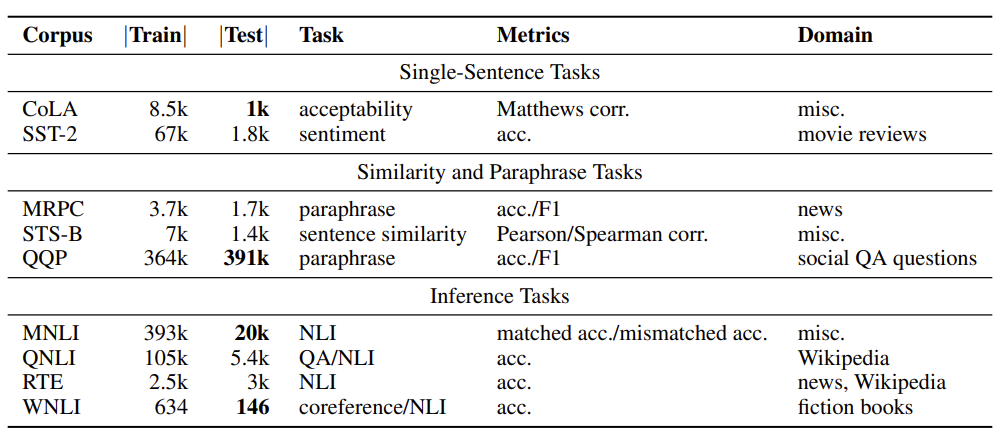

### 4.2 SQuAD

SQuAD (Standford Question Answering Dataset) 是一个阅读理解数据集，由文章、问题和答案组成。

文章来源于维基百科，问题由标注者基于文章提出，答案是从文章中找出来的一段话，标注者会将答案在文章中的起始位置标注出来。

以下是一条数据示例：

- **context**: Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
- **question**: What is in front of the Notre Dame Main Building?
- **answers**: `{ "text": [ "a copper statue of Christ" ], "answer_start": [ 188 ] }`

其中`answer_start`表示答案在原文中的位置（以字符为单位）

对于有的问题，可能在文中找到多个满足要求的答案。因此，SQuAD在验证集中针对一个问题会提供3个可能的答案，从而放宽评估标准：

- **context**: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
- **question**: Where did Super Bowl 50 take place?
- **answers**: `{ "text": [ "Santa Clara, California", "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California." ], "answer_start": [ 403, 355, 355 ] }`



In [ ]:
context = """Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary."""
answer_start = 188
answer_text = "a copper statue of Christ"
context[answer_start:answer_start+len(answer_text)]

'a copper statue of Christ'

SQuAD 2.0则是在SQuAD的10w个问题基础上引入了5w个无法回答的问题（即原文中不存在问题的答案），期待模型不仅能学会回答可回答的问题，还能拒绝回答无法回答的问题。

以下是一个无法回答的问题的示例：

- **context**: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
- **question**: Who gave their name to Normandy in the 1000's and 1100's
- **answers**: `{ "text": [], "answer_start": [] }`

### 4.3 SWAG

SWAG（Situations With Adversarial Generations）任务给定一个句子`sent1`和下一个句子`sent2`的开头几个单词，同时给定4个选项`ending0,ending1,ending2,ending3`，要求从这4个句子中选出最佳选项来补全`sent2`。

例如：

```json
{
  "video-id": "anetv_dm5WXFiQZUQ",
  "fold-ind": "18419",
  "startphrase", "He rides the motorcycle down the hall and into the elevator. He",
  "sent1": "He rides the motorcycle down the hall and into the elevator."
  "sent2": "He",
  "gold-source": "gold",
  "ending0": "looks at a mirror in the mirror as he watches someone walk through a door.",
  "ending1": "stops, listening to a cup of coffee with the seated woman, who's standing.",
  "ending2": "exits the building and rides the motorcycle into a casino where he performs several tricks as people watch.",
  "ending3": "pulls the bag out of his pocket and hands it to someone's grandma.",
  "label": 2,
}
```

SWAG中共包含113k条数据，73k训练，20k验证，20k测试。数据来源于视频字幕。

## 5. 使用datasets包加载数据

以上提到的数据集都在BERT原论文的实验中被用来对预训练的BERT进行微调。

现在，这些数据集都被公开在了[Hugging Face](https://huggingface.co/)上。

Hugging Face是一个开源AI社区，用户可以在这里发布或下载各种开源的模型和数据集。

Hugging Face也是AI工具的开发者，用户可以基于它们开发的各种开源Python库来进行模型训练、模型推理等工作。

我们可以使用Hugging Face开发的`datasets`来加载上面的数据集。

1. 安装`datasets`

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


2. 去[Hugging Face](https://huggingface.co/)上搜索想要的数据集
3. 复制数据集的名称，用代码加载数据集

In [ ]:
from datasets import load_dataset


squad = load_dataset(
  "rajpurkar/squad",  # 数据集名称
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

4. 查看数据集的相关信息（这里可以看到，SQuAD由`train`和`validation`两个部分（splits）构成，分别是训练集和验证集，分别有87599和10570条数据）

In [ ]:
squad

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

5. `load_dataset`可以指定所需加载的`split`

In [ ]:
squad_train = load_dataset(
  "rajpurkar/squad",  # 数据集名称
  split="train",  # split名称
)

In [ ]:
squad_train

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

6. 可以对`split`进一步切分

In [ ]:
squad_train_top_1k = load_dataset(
  "rajpurkar/squad",  # 数据集名称
  split="train[:1000]",  # train split中的前1k条
)

In [ ]:
squad_train_top_1k

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})

In [ ]:
squad_train_top_10p = load_dataset(
  "rajpurkar/squad",  # 数据集名称
  split="train[:10%]",  # train split中的前10%
)

In [ ]:
squad_train_top_10p

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 8760
})

In [ ]:
squad_train_top_10p_last_10p = load_dataset(
  "rajpurkar/squad",  # 数据集名称
  split="train[:10%]+train[-10%:]",  # train split中的前10%和后10%
)

In [ ]:
squad_train_top_10p_last_10p

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 17520
})

7. 有的数据集包含多个`subset`，在加载时必须指定一个

In [ ]:
try:
  glue = load_dataset("nyu-mll/glue")
except Exception as e:
  print(e)

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

Config name is missing.
Please pick one among the available configs: ['ax', 'cola', 'mnli', 'mnli_matched', 'mnli_mismatched', 'mrpc', 'qnli', 'qqp', 'rte', 'sst2', 'stsb', 'wnli']
Example of usage:
	`load_dataset('nyu-mll/glue', 'ax')`


In [ ]:
glue_qnli = load_dataset("nyu-mll/glue", "qnli")

train-00000-of-00001.parquet:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/872k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/877k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/104743 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5463 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5463 [00:00<?, ? examples/s]

In [ ]:
glue_qnli

DatasetDict({
    train: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 104743
    })
    validation: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
    test: Dataset({
        features: ['question', 'sentence', 'label', 'idx'],
        num_rows: 5463
    })
})

8. 遍历数据集

In [ ]:
for data in squad_train:
  print(data)
  break

{'id': '5733be284776f41900661182', 'title': 'University_of_Notre_Dame', 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}


In [ ]:
squad_train[3]

{'id': '5733be284776f41900661181',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'What is the Grotto at Notre Dame?',
 'answers': {'text': ['a Marian place of prayer and reflection'],
  'answer_start': [381]}}

## 6. 微调分类任务

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


现写

In [ ]:
from datasets import load_dataset


train_dataset = load_dataset("nyu-mll/glue", "sst2", split="train[:1000]")
eval_dataset = load_dataset("nyu-mll/glue", "sst2", split="validation")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/72.8k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/148k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [ ]:
# 骨架模型: BERT
# 任务: 序列分类，SequenceClassification
from transformers import BertForSequenceClassification


model = BertForSequenceClassification.from_pretrained("google-bert/bert-base-uncased")
model = model.cuda()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import BertTokenizer


tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenizer("Hello, world!")["input_ids"]

[101, 7592, 1010, 2088, 999, 102]

In [ ]:
train_dataset[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0}

In [ ]:
def process_data(example):
  return tokenizer(example["sentence"], padding="max_length", truncation=True)

In [ ]:
train_dataset_proc = train_dataset.map(process_data)
eval_dataset_proc = eval_dataset.map(process_data)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

In [ ]:
train_dataset_proc[0]

{'sentence': 'hide new secretions from the parental units ',
 'label': 0,
 'idx': 0,
 'input_ids': [101,
  5342,
  2047,
  3595,
  8496,
  2013,
  1996,
  18643,
  3197,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
trainer = Trainer(
    model,
    args=TrainingArguments(
      output_dir="./output_dir",
      report_to="none",
      max_steps=100,
      evaluation_strategy="steps",
      eval_steps=20,
    ),
    train_dataset=train_dataset_proc,
    eval_dataset=eval_dataset_proc,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
20,0.161400,0.468313


KeyboardInterrupt: 

## 7. BERT源码阅读与Debug